# Regional Trends

This notebook intends to investigate the computation of the trends from regional Time Series (instead of averaging r

#### import modules

In [1]:
import pyaerocom as pya
import pandas as pd
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import scipy.stats as stats
import simplejson as json
import numpy as np
import datetime
import copy
import pwlf
import seaborn as sns

Initating pyaerocom configuration
Checking database access...
Checking access to: /lustre/storeA
Access to lustre database: True
Init data paths for lustre
Expired time: 0.022 s


#### computation parameters

In [2]:
min_dobs = 300 #minimum number of daily observations available in order to keep the station
min_nstat = 2 #minimum number of stations required to compute median
sig = 0.95 #significance
min_dim = 5 #minimum number of days required to compute monthly mean
min_mis = 1 #minimum number of months required to compute seasonal mean
min_siy = 4 #minimum number of seasons required to compute annual mean
nseg = 2 #number of segments if no significant linear trend on the time series is found
use_obs_seg = True #if use same segments for model and bias than the ones found in obs (to be run before)

#### dedicated functions

In [3]:
def to_jsdate(dates):
    """Convert datetime vector to jsdate vector"""
    epoch = np.datetime64('1970-01-01')
    return (dates - epoch).astype('timedelta64[ms]').astype(int)

In [4]:
def write_ts(TS, region):
    source = 'AERONET-Sun'
    layer = 'Column'
    fn = path_out + 'regions_ts/OBS-' + source + ':' + var + '_' + layer + '_MOD-None:None_' + region + '.json'
    #export TS as json file
    with open(fn, 'w') as fp:
        json.dump(TS, fp, sort_keys=True, ignore_nan=True)

In [5]:
def write_all_ts(TS):
    source = 'AERONET-Sun'
    layer = 'Column'
    fn = path_out + 'regions_all_ts/OBS-' + source + ':' + var + '_' + layer + '_MOD-None:None' +  '.json'
    #export TS as json file
    with open(fn, 'w') as fp:
        json.dump(TS, fp, sort_keys=True, ignore_nan=True)

In [6]:
def write_map(MAP):
    source = 'AERONET-Sun'
    layer = 'Column'
    fn = path_out + 'regions_map/OBS-' + source + ':' + var + '_' + layer + '_MOD-None:None' + '.json'
    json.dumps(MAP, sort_keys=True, default=str)
    with open(fn, 'w') as fp:
        json.dump(MAP, fp, sort_keys=True, ignore_nan=True)

In [7]:
def compute_trend_error(m, m_err, v0, v0_err):
    delta_sl = m_err / v0
    delta_ref = m * v0_err / v0**2
    return np.sqrt(delta_sl**2 + delta_ref**2) * 100

In [8]:
def compute_trend(x, y, kind, region):
    #function that provide a linear fit, if significant. If not, break out the function within nseg.
    
    #mann kendall test
    tau, pval = stats.kendalltau(x, y)
    
    #theil sen slope
    a, b, low_slope, up_slope = stats.mstats.theilslopes(y, x, alpha=sig)
    #reproject on the whole period asked
    xb = np.arange(int(period.split('-')[0]),int(period.split('-')[1])+1)
    reg = [a * i + b for i in xb]
    rel_slope = a * 100 / reg[0]

    slope_err = np.mean([abs(a - low_slope), abs(a - up_slope)])
    v0_err_data = np.mean(np.abs(y - [a * i + b for i in x]))
    trend_err = compute_trend_error(m=a, m_err=slope_err, v0=reg[0], v0_err=v0_err_data)


    trend = {
        str(xb[0])+'-'+str(xb[-1]): {
            'x': xb,
            'xdate': [np.datetime64(str(y)+'-06-01') for y in xb],
            'y': reg,
            'a': a,
            'b': b,
            'rel_slp': rel_slope,
            'pval': pval,
            'err_rel_slp': trend_err
        }
    }
    
    trend1 = copy.copy(trend)
    pval1 = copy.copy(pval)
    short_period = False
    
    
    #if (kind=='obs' and pval>(1-sig)) or ((kind!='obs' and use_obs_seg)):
    if (kind=='obs') or ((kind!='obs' and use_obs_seg)):
    
        #first, find break points
        #print('needs to break the series')
        # initialize piecewise linear fit with your x and y data
        my_pwlf = pwlf.PiecewiseLinFit(x, y)
        if kind!='obs' and use_obs_seg:
            #print('use obs segments')
            # fit the data for nseg line segments
            segs = list(OBS_MAP[region]['trends']['trends'].keys())
            if len(segs)<=1:
                #print('obs do not have segments')
                #print(trend)
                return trend
            else:
                trend = {}
                breaks = [int(segs[0].split('-')[0]), int(segs[0].split('-')[1]), int(segs[1].split('-')[1])]
                #print('obs breaks: ',breaks)
        else:
            trend = {}
            # fit the data for nseg line segments
            breaks = [int(round(x)) for x in my_pwlf.fit(nseg)]
            
        #loop over segments
        for i in np.arange(nseg):
            mask = [(x>=breaks[i]) & (x<=breaks[i+1])]
            x2 = x[mask]
            y2 = y[mask]
            
            if (len(x2)>3):
                #mann kendall test
                tau, pval = stats.kendalltau(x2, y2)
                #theil sen slope
                a, b, low_slope, up_slope = stats.mstats.theilslopes(y2, x2, alpha=sig)
                #reproject on the whole period asked for first and last segment
                xb = x2
                if i==0:
                    xb = np.arange(int(period.split('-')[0]),x2[-1]+1)
                if i==nseg:
                    xb = np.arange(x2[0],int(period.split('-')[1])+1)
                    
                reg = [a * i + b for i in xb]
                rel_slope = a * 100 / reg[0]
                
                slope_err = np.mean([abs(a - low_slope), abs(a - up_slope)])
                v0_err_data = np.mean(np.abs(y2 - [a * i + b for i in x2]))
                trend_err = compute_trend_error(m=a, m_err=slope_err, v0=reg[0], v0_err=v0_err_data)

                trend[str(xb[0])+'-'+str(xb[-1])] = {
                    'x': xb,
                    'xdate': [np.datetime64(str(y)+'-06-01') for y in xb],
                    'y': reg,
                    'a': a,
                    'b': b,
                    'rel_slp': rel_slope,
                    'pval': pval,
                    'err_rel_slp': trend_err
                }
            else:
                xb = x2
                trend[str(xb[0])+'-'+str(xb[-1])] = {
                    'x': [],
                    'xdate': [],
                    'y': [],
                    'a': None,
                    'b': None,
                    'rel_slp': None,
                    'pval': None,
                    'err_rel_slp': None
                }
                short_period = True
    
    #compare p-values
    if kind=='obs':
        seg_pval = []
        for seg in trend.keys():
            if (trend[seg]['pval']!=None):
                seg_pval.append(trend[seg]['pval'])
        if min(seg_pval)>=pval1 or short_period==True:
            trend = trend1
    
    #compute trend along time series
    return trend

In [9]:
def process_trend(data, kind, period, obs=None, colocate_time=True, colocate_space=True, 
                  plot=True, write_json=False, ymin=None, ymax=None, ylabel=None, save_plot=False):
    #by default, colocate model in space and time
    MAP = {}
    DF = {}
    ALL_TS = {}
    regions = pya.region.all()
    regions = ['EUROPE', 'ASIA', 'AUSTRALIA', 'NAFRICA', 'SAFRICA', 'NAMERICA', 'SAMERICA']
    
    #computation region by region
    for region in regions:
        f = pya.Filter(region)
        if kind == 'obs':
            try:
                sub = f(data)
                var = data.vars_to_retrieve[0]
            except:
                print('No station found in the area')
                MAP[region] = {
                    'name': region,
                    'min_lon': pya.Region(region).lon_range[0],
                    'max_lon': pya.Region(region).lon_range[1],
                    'min_lat': pya.Region(region).lat_range[0],
                    'max_lat': pya.Region(region).lat_range[1],
                    'trends': {},
                    'nmax': 0,
                    'stations': [],
                }
                continue
        elif kind == 'mod' or kind == 'bias':
            if obs==None:
                print('kind is model or bias. Needs to pass an obs dataset')
            else:
                try:
                    sub = f(obs)
                    var = data.var_name
                except:
                    print('No station found in the area')
                    MAP[region] = {
                        'name': region,
                        'min_lon': pya.Region(region).lon_range[0],
                        'max_lon': pya.Region(region).lon_range[1],
                        'min_lat': pya.Region(region).lat_range[0],
                        'max_lat': pya.Region(region).lat_range[1],
                        'trends': {},
                        'nmax': 0,
                        'stations': [],
                    }
                    continue

        #for each subset, creates a dataframe containing all stations timeseries
        #first, get station data
        data_all = sub.to_station_data_all()['stats']
        obs_all = copy.copy(data_all)
        
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        #if model 
        if kind == 'mod':
            if colocate_space: 
                #first, get list of stations name, lat and lon
                stations = { 'name': [], 'lat': [], 'lon': []  }

                for stat in data_all:
                    stations['name'].append(stat['station_name'])
                    stations['lat'].append(stat['station_coords']['latitude'])
                    stations['lon'].append(stat['station_coords']['longitude'])

                data_all = data.to_time_series(longitude=stations['lon'], latitude=stations['lat'],  add_meta=dict(station_name = stations['name']))
            else:
                #creates a filter for the region
                f = pya.Filter(region)
                data_all = f(data)
                med_area = data_all.get_area_weighted_timeseries()
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        
        
        #initialize pandas DataFrame
        df = pd.DataFrame()
        
        stations = []
        if kind=='mod' and colocate_space==False:
            med = med_area[var]
            top = med
            bottom = med
            ts = med.to_frame()
            ts.set_axis([var+'_'+region], axis=1, inplace=True)
            df = pd.concat([df, ts], axis=1)
        else:
            for i, station in enumerate(data_all):
                stat_name = station.station_name
                clear_output(wait=True)
                print('region: ', region)
                print('station: ', stat_name)
                ts_type = station.ts_type
                #set individual time series as dataframe

                #extract pandas series and convert it to datframe
                ts = data_all[i][var].to_frame()
                ts.set_axis([var+'_'+stat_name], axis=1, inplace=True)

                if ts_type == 'daily':
                    if ts.count()[0]>=min_dobs:
                        #concatenates to main dataframe
                        df = pd.concat([df, ts], axis=1)
                else :
                    #concatenates to main dataframe
                    df = pd.concat([df, ts], axis=1)

                stations.append({
                    'name': stat_name,
                    'lat': station.latitude,
                    'lon': station.longitude
                })
            clear_output(wait=False)
                
            #caluclates median and envelope with quartiles
            med = df.median(axis=1)
            top = df.quantile(q=0.75,axis=1)
            bottom = df.quantile(q=0.25,axis=1)
            #requires at least n measurements to provide a valid median
            n = df.count(axis=1, numeric_only=False)
            med = med[n>min_nstat]
            top = top[n>min_nstat]
            bottom = bottom[n>min_nstat]
        
        
        #if model, colocates in time with obs
        if kind=='mod' and colocate_time:
            if region in OBS_DF.keys():
                df =df[OBS_DF[region].shift(-12, freq='H')>=0]
                #caluclates median and envelope with quartiles
                med = df.median(axis=1)
                top = df.quantile(q=0.75,axis=1)
                bottom = df.quantile(q=0.25,axis=1)
                #requires at least n measurements to provide a valid median
                n = df.count(axis=1, numeric_only=False)
                med = med[n>min_nstat]
                top = top[n>min_nstat]
                bottom = bottom[n>min_nstat]
            else:
                continue

        #calculates monthly averages for the plots
        dcount = med.groupby(pd.Grouper(freq='M')).count()
        mmed = med.groupby(pd.Grouper(freq='M')).mean().where(dcount>=min_dim)
        mtop = top.groupby(pd.Grouper(freq='M')).mean().where(dcount>=min_dim)
        mbottom = bottom.groupby(pd.Grouper(freq='M')).mean().where(dcount>=min_dim)
        
        #seasonal averages
        mcount = mmed.groupby(pd.Grouper(freq='Q')).count()
        smed = mmed.groupby(pd.Grouper(freq='Q')).mean().where(mcount>=min_mis)
        
        #yearly averages from seasonal averages
        scount = smed.groupby(pd.Grouper(freq='A')).count()
        ymed = smed.groupby(pd.Grouper(freq='A')).mean().where(scount>=min_siy)
        ymed = ymed.shift(-6, freq ='MS')
        
        y_min = int(period.split('-')[0])
        y_max = int(period.split('-')[1])

        #prepare arrays for trends computation
        x = ymed.index.year.values
        xplot = ymed.index
        y = ymed.values
        #get only valid values
        x = x[~np.isnan(y)]
        xplot = xplot[~np.isnan(y)]
        y = y[~np.isnan(y)]
        #restrict to years within period
        xok, yok = [], []
        for i,_ in enumerate(x):
            if x[i]>=y_min and x[i]<=y_max:
                xok.append(x[i])
                yok.append(y[i])
        xok = np.array(xok)
        yok = np.array(yok)
        
        #write ts json file
        TS = {
            "daily": {
                "jsdate": to_jsdate(med.index).tolist(),
                "data": med.values.tolist(),
                "top": top.values.tolist(),
                "bottom": bottom.values.tolist()
            },
            "monthly": {
                "jsdate": to_jsdate(mmed.index).tolist(),
                "data": mmed.values.tolist(),
                "top": mtop.values.tolist(),
                "bottom": mbottom.values.tolist()
            },
            "yearly": {
                "jsdate": to_jsdate(ymed.index).tolist(),
                "data": ymed.values.tolist(),
            },
            "trends": {}
        }
        
        #trends computation
        if len(xok)==0:
            print('No Data Available in Selected Period')
            MAP[region] = {
                'name': region,
                'min_lon': pya.Region(region).lon_range[0],
                'max_lon': pya.Region(region).lon_range[1],
                'min_lat': pya.Region(region).lat_range[0],
                'max_lat': pya.Region(region).lat_range[1],
                'trends': TS,
                'nmax': len(df.columns),
                'stations': stations,
            }
            continue
        trend = compute_trend(xok, yok, kind, region)

        if plot:
            plotTS(mmed, mbottom, mtop, ymed, trend, region, ymin, ymax, ylabel, save_plot)


        #store every portions of the trend
        for seg in trend.keys():
            if trend[seg]['rel_slp']!=None:
                jsdate = to_jsdate(trend[seg]['xdate']).tolist()
            else:
                jsdate = []
            TS["trends"][seg] = {
                'pval': trend[seg]['pval'],
                'rel_slp': trend[seg]['rel_slp'],
                'abs_slp': trend[seg]['a'],
                'reg0': trend[seg]['b'],
                'n': len(trend[seg]['x']),
                'data': trend[seg]['y'],
                'jsdate': jsdate,
                'err_rel_slp': trend[seg]['err_rel_slp']
            }

        #export TS as json file
        if write_json:
            write_ts(TS, region)

        #append to map dict
        MAP[region] = {
            'name': region,
            'min_lon': pya.Region(region).lon_range[0],
            'max_lon': pya.Region(region).lon_range[1],
            'min_lat': pya.Region(region).lat_range[0],
            'max_lat': pya.Region(region).lat_range[1],
            'trends': TS,
            'nmax': len(df.columns),
            'stations': stations,
        }
        
        ALL_TS[region] = TS
        DF[region] = df

    #export MAP as json file
    if write_json:
        write_map(MAP)
        write_all_ts(ALL_TS)
    
    return TS, MAP, DF

In [10]:
#import seaborn style
sns.set()
sns.set_context("paper")
#sns.set_style("whitegrid")
sns.color_palette("muted")
#since each figure will be a subfigure, increase font_size
fscale = 1.3
sns.set(font_scale=fscale)

def plotTS(mmed, mbottom, mtop, ymed, trend, region, ymin, ymax, ylabel, save_plot):
    #font style
    bold_start = r"$\bf{"
    bold_end = "}$"
    italic_start = r"$\it{"
    italic_end = "}$"
    
    #plot that   
    fig, ax = plt.subplots(figsize=(9, 3), dpi= 300, facecolor='w', edgecolor='k')
    
    #plot monthly averages
    plt.fill_between(mmed.index, mbottom.values, mtop.values, alpha=.2)
    plt.plot(mmed, lw=2, alpha=.5)
    plt.plot(ymed, 'b.', lw=0, ms=12, alpha=1)
    plt.ylim(bottom=0)
    #plot every portions of the trend
    for nseg, seg in enumerate(trend.keys()):
        if len(trend[seg]['xdate'])>0:
            if trend[seg]['pval']<=0.1:
                ls = '-'
                trend_style_start = bold_start
                trend_style_end = bold_end
                unit = '\ \%/yr '
                pm = '\ ±\ '
            if trend[seg]['pval']>0.1 and trend[seg]['pval']<=0.2:
                ls = '--'
                trend_style_start = ''
                trend_style_end = ''
                unit = ' %/yr '
                pm = ' ± '
            if trend[seg]['pval']>0.2:
                ls = ':'
                trend_style_start = italic_start
                trend_style_end = italic_end
                unit = '\ \%/yr '
                pm = '\ ±\ '
            #plot the trend
            plt.plot(trend[seg]['xdate'], trend[seg]['y'], lw=2, linestyle=ls, color=sns.color_palette()[3], alpha=.5)
            
            #write the period
            string = seg+': '
            #xstr = trend[seg]['xdate'][0]+100 #plot when period start. but the text might be out of the plot  when the period starts near the end
            #ystr = ymin+0.9*(ymax-ymin)
            xstr = 0.02
            ystr = 0.9-0.1*nseg
            plt.text(xstr, ystr, string,
                     horizontalalignment='left', verticalalignment='center', 
                     color=(.3,.3,.3), fontsize = 8*fscale,
                     transform=ax.transAxes
                     )
            
            #write the trend
            #xstr = trend[seg]['xdate'][0]+100
            #ystr = ymin+0.8*(ymax-ymin)
            xstr = 0.15
            ystr = 0.9-0.1*nseg
            string = trend_style_start+'{:.1f}'.format(trend[seg]['rel_slp'])+pm+'{:.1f}'.format(trend[seg]['err_rel_slp'])+unit+trend_style_end
            string+='; '+italic_start+'p'+italic_end+'-val: '+'{:.1e}'.format(trend[seg]['pval'])
            plt.text(xstr, ystr, string,
                     horizontalalignment='left', verticalalignment='center', 
                     color=(.2,.2,.2), fontsize = 9*fscale,
                     transform=ax.transAxes,
                     )

            #plot vertival line
            if nseg>0:
                plt.axvline(x=trend[seg]['xdate'][0], ls=':', lw=2, color=(.5,.5,.5), alpha=.6)

    #ax.set_title(region+' '+period)
    if ylabel!=None:
        ax.set_ylabel(ylabel)
    else:
        ax.set_ylabel(var)
    if ymin!=None:
        plt.ylim(bottom=ymin)
    if ymax!=None:
        plt.ylim(top=ymax)
        
    #write region at top-right
    ax.text(.97,.85,region,horizontalalignment='right',verticalalignment='center',
            transform=ax.transAxes, fontsize = 14*fscale)
    
    #remmove vertical grid
    sns.despine(left=True)
    
    if save_plot:
        plt.savefig('figs/ts/'+source+'-'+var+'-'+region+'.png', dpi=300, bbox_inches='tight')

#### start with Observations

In [11]:
#pya.browse_database('AERONET*')
path_out = '../../aerosoltrends/data/test/'
#in this notebook, work only with one period
period = '1995-2018'

No Data Available in Selected Period


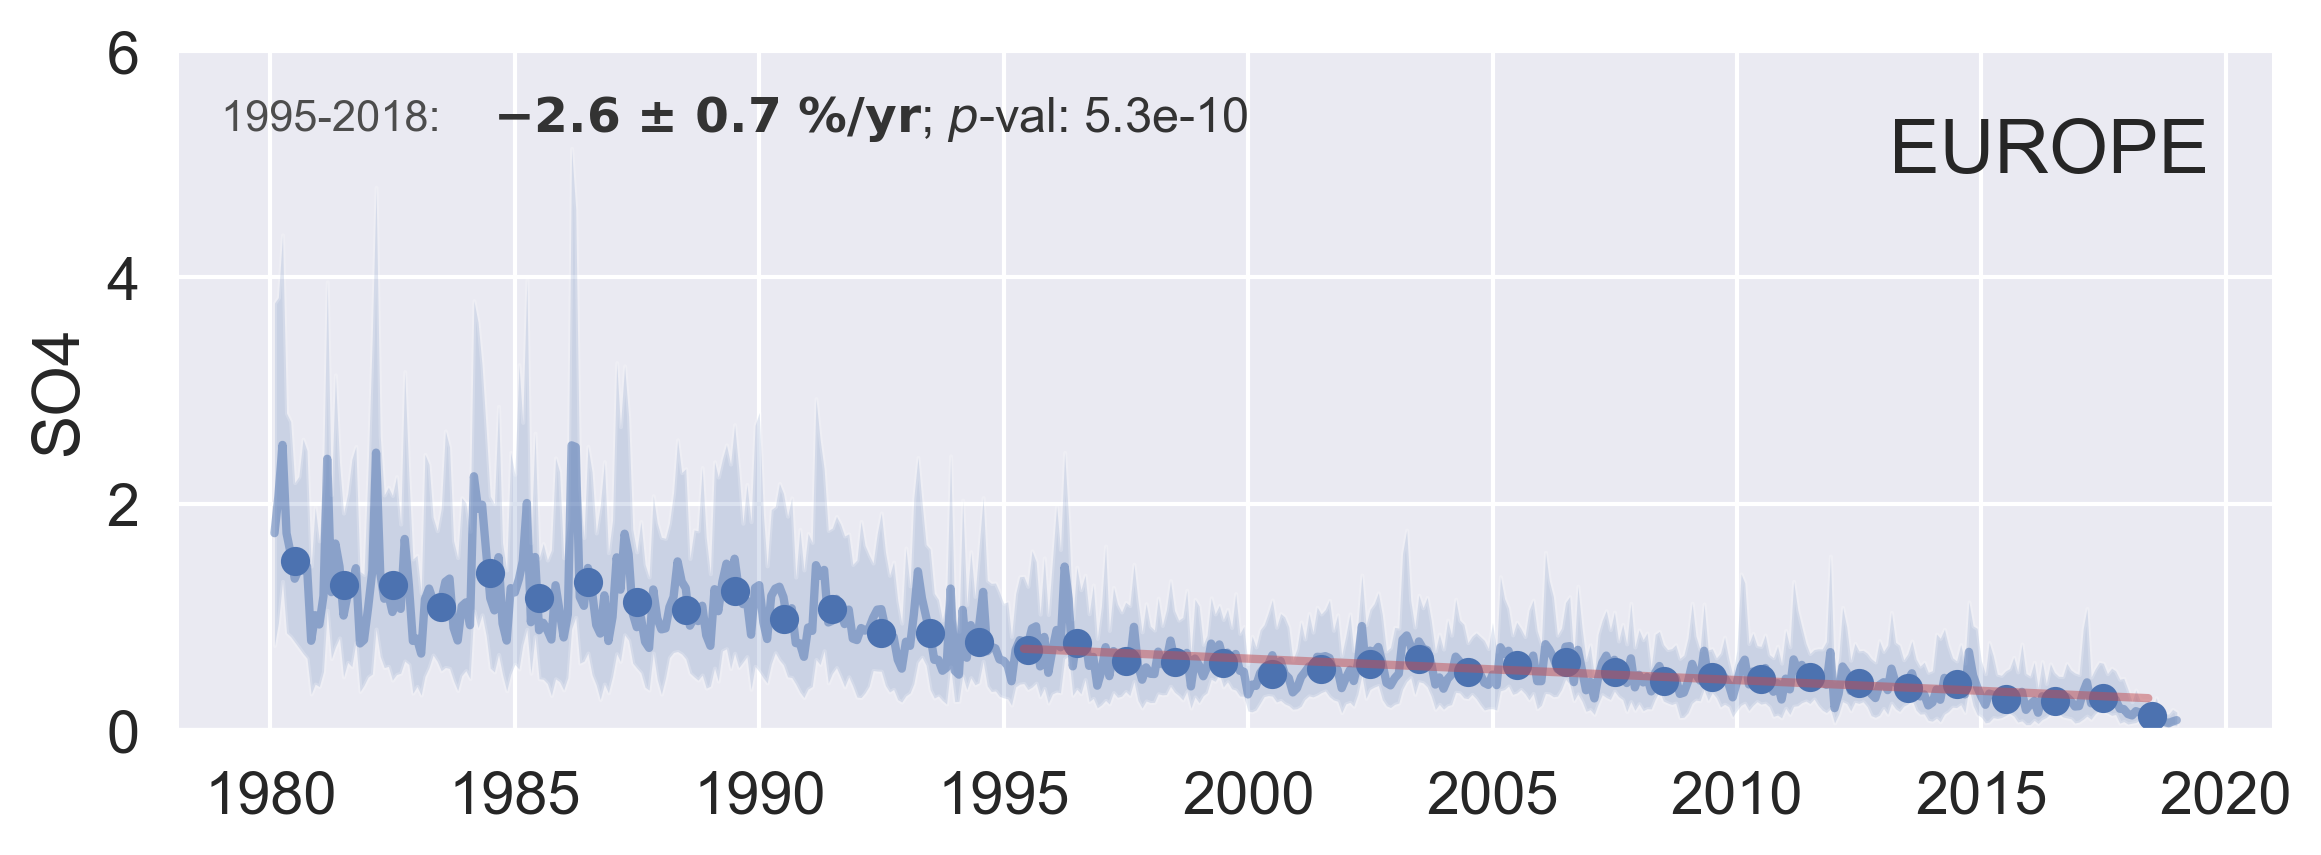

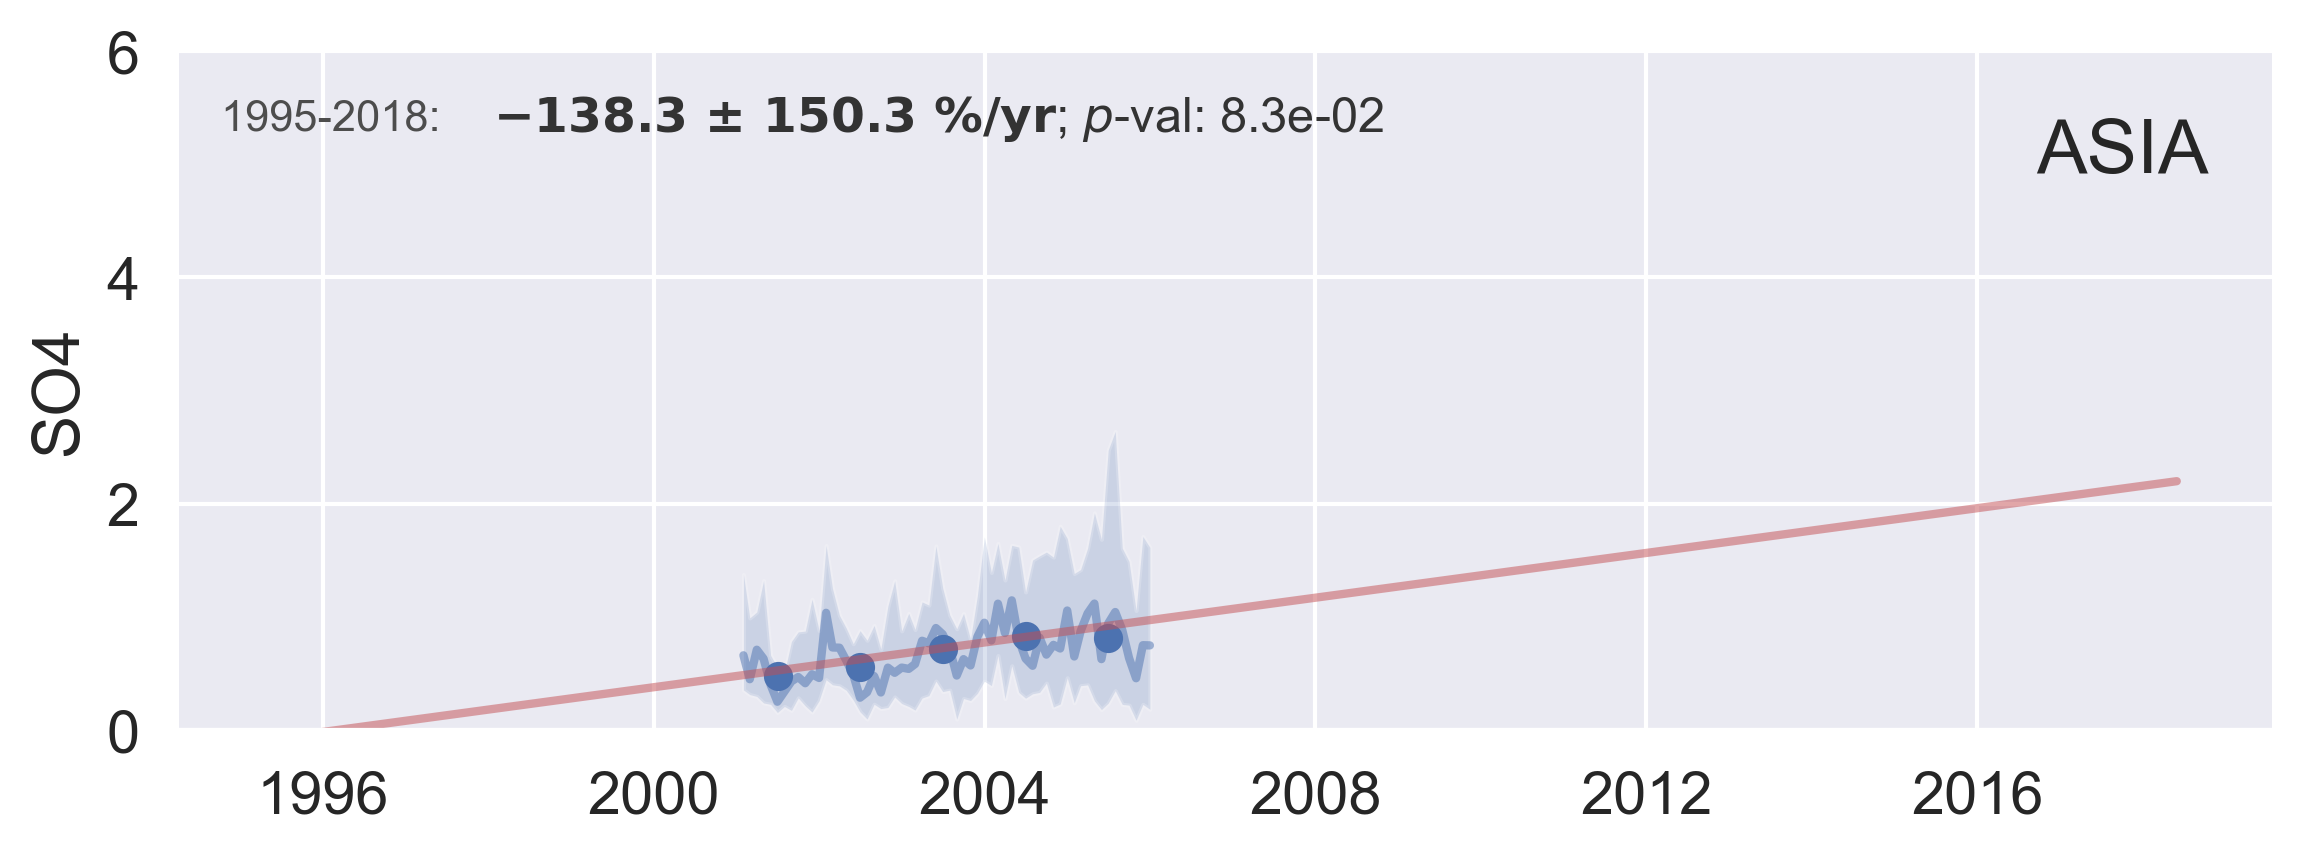

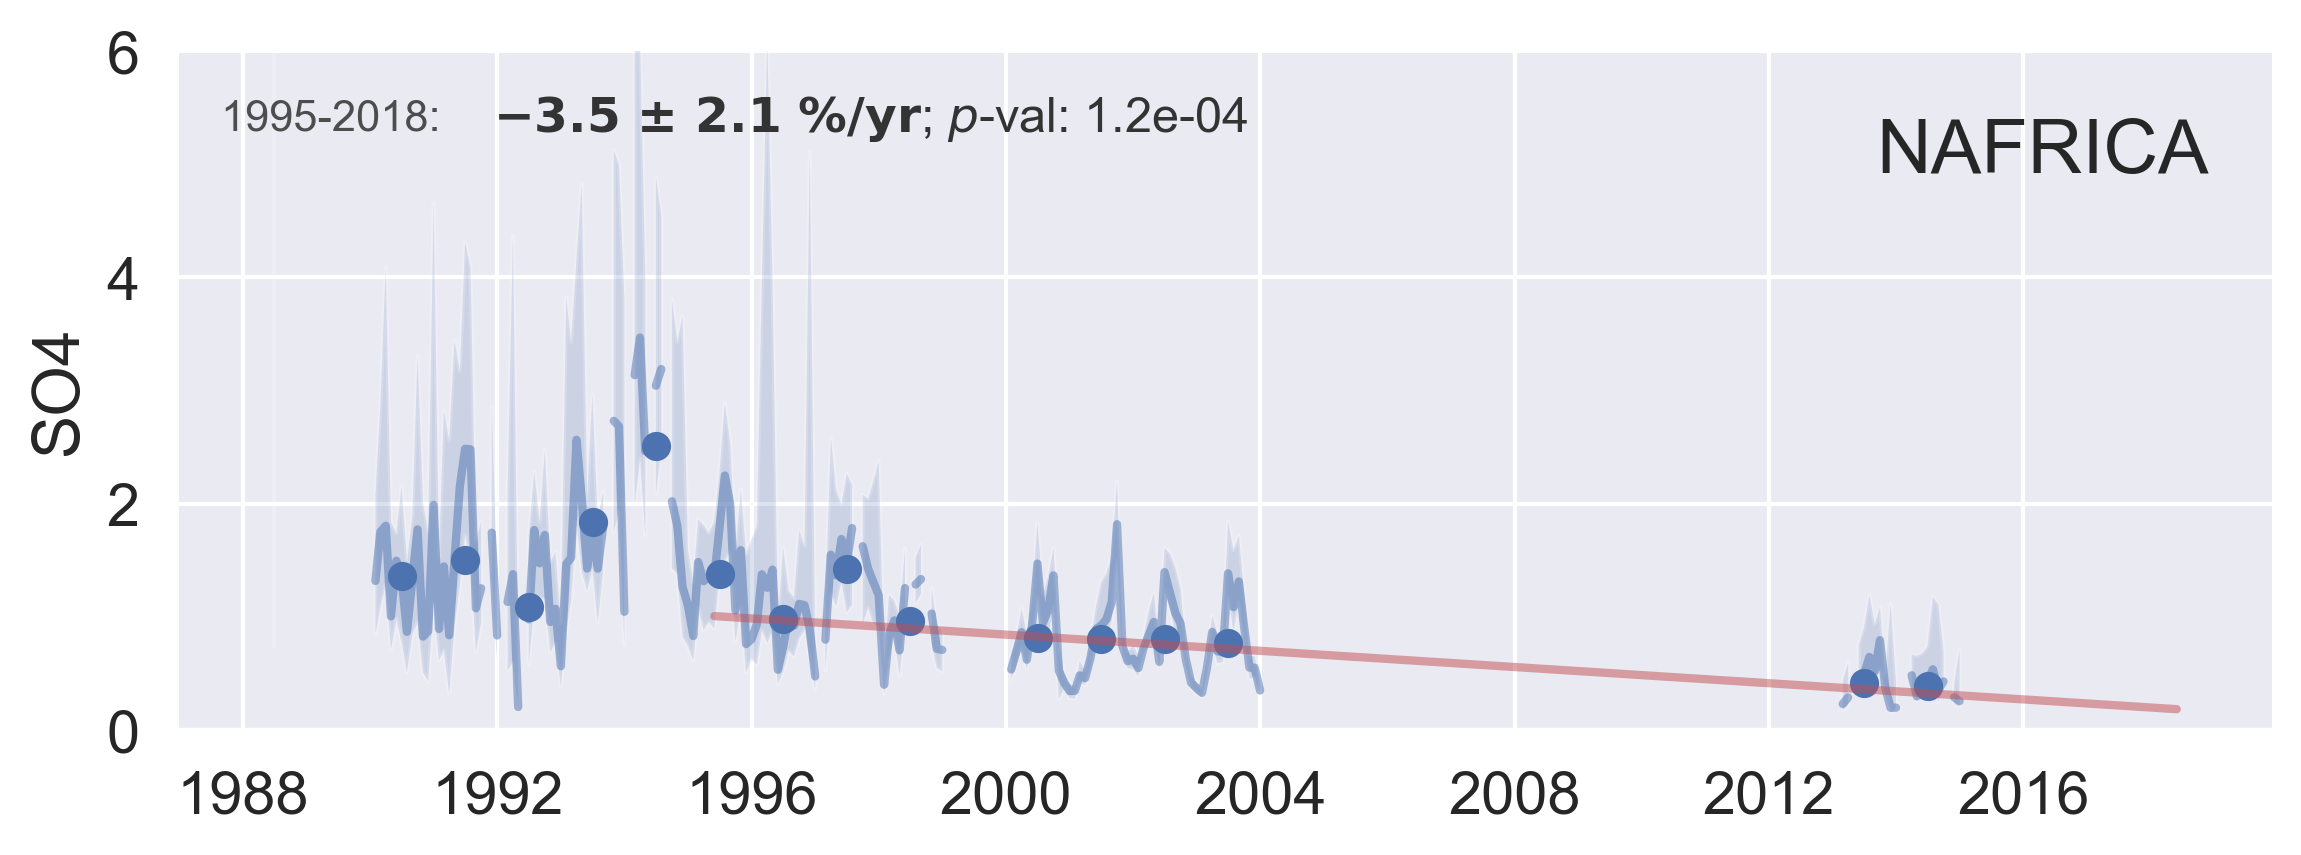

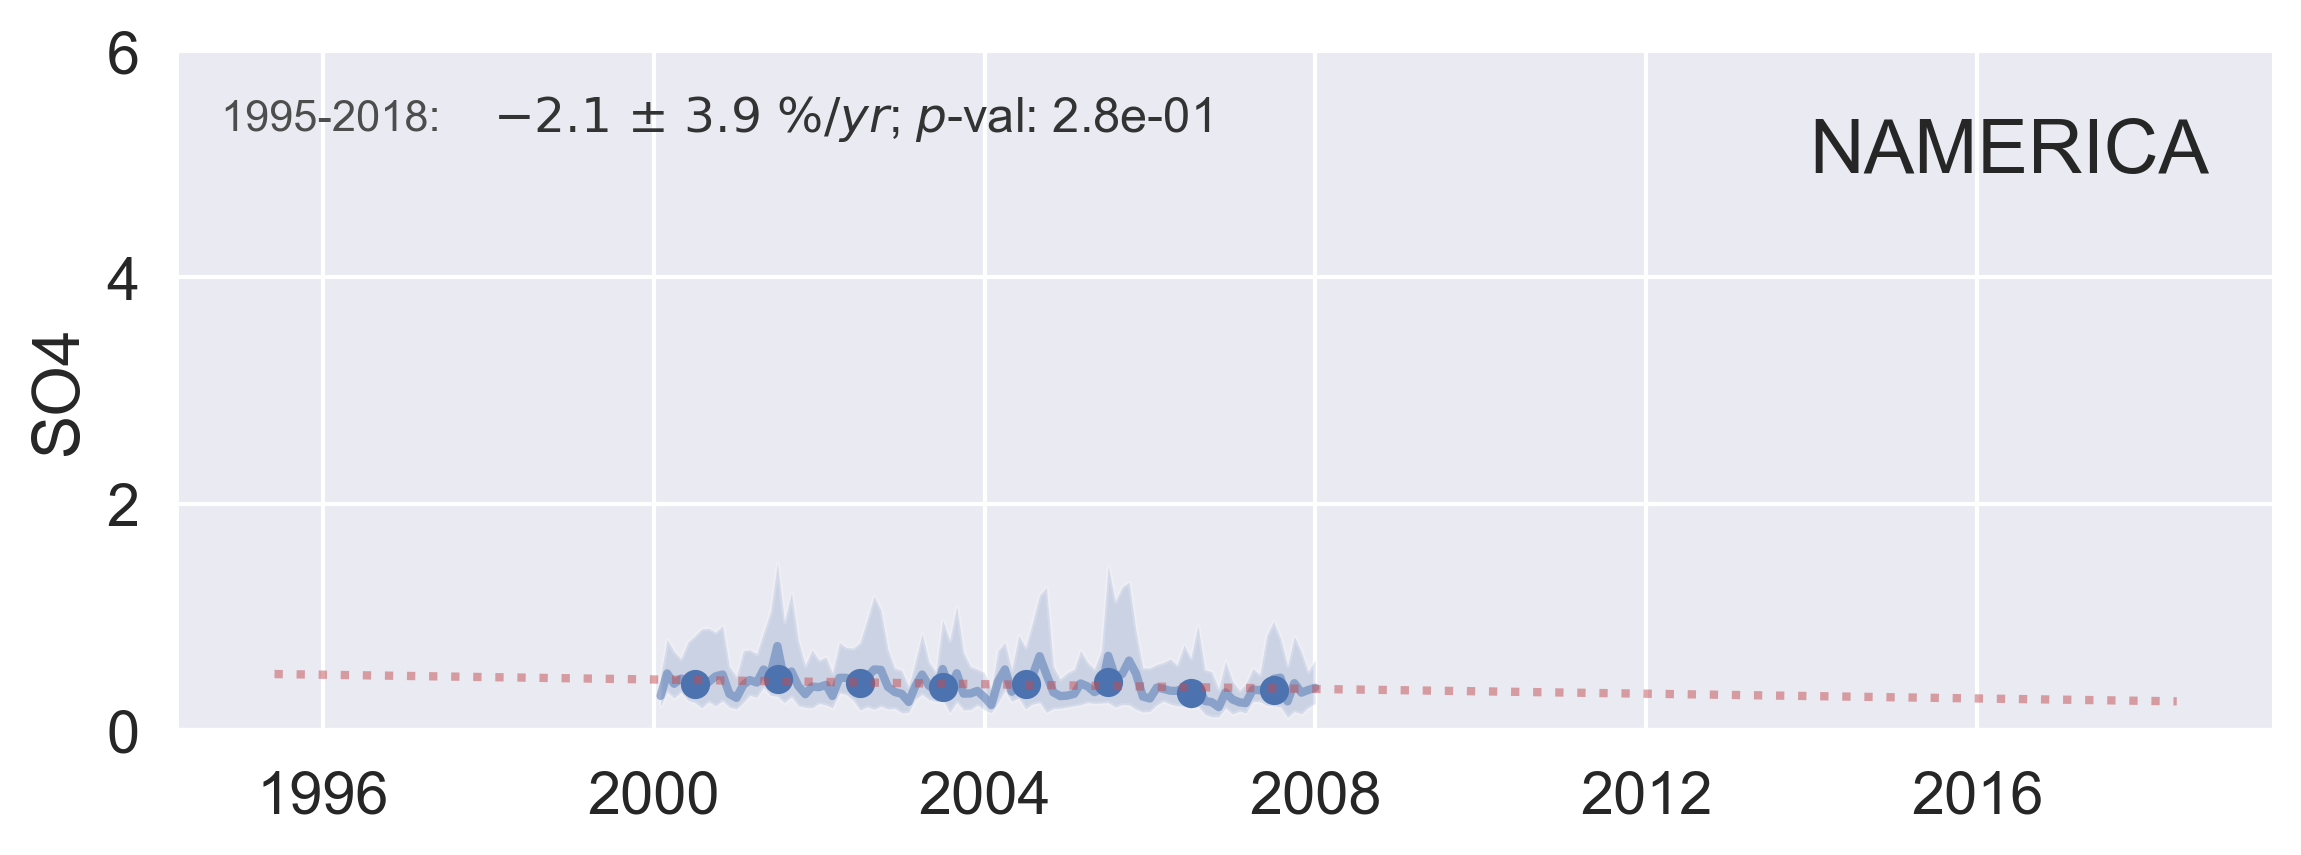

In [12]:
var =  'sconcso4' #'ang4487aer' 'od550aer' 'od550gt1aer' 'od550lt1aer' 'sconcpm10' 'sconcpm25' 'sconcso4'
if var=='od550aer':
    source = 'AeronetSunV3Lev2.daily'
    ymin, ymax = 0, 0.8
    ylabel = 'AOD'
    min_dim = 5
if var=='ang4487aer':
    source = 'AeronetSunV3Lev2.daily'
    ymin, ymax = 0, 2.5
    ylabel = 'AE'
    min_dim = 5
if var=='od550gt1aer':
    source = 'AeronetSDAV3Lev2.daily'
    ymin, ymax = 0, 0.8
    ylabel = 'AOD>1µm'
    min_dim = 5
if var=='od550lt1aer':
    source = 'AeronetSDAV3Lev2.daily'
    ymin, ymax = 0, 0.8
    ylabel = 'AOD<1µm'
if var=='sconcpm10':
    source = 'EBASMC'
    ymin, ymax = 0, 60
    ylabel = 'PM10'
    min_dim = 4 #some weekly measurements..
if var=='sconcpm25':
    source = 'EBASMC'
    ymin, ymax = 0, 30
    ylabel = 'PM25'
    min_dim = 4 #some weekly measurements..
if var=='sconcso4':
    source = 'EBASMC'
    ymin, ymax = 0, 6
    ylabel = 'SO4'
    min_dim = 4 #weekly measurements!
#if var=='wetconcso4':
#    source = 'EBASMC'
#    ymin, ymax = 0, 50
#    ylabel = 'SO4'
#    min_dim = 1 #weekly measurements!
    
obs_source = source
reader = pya.io.ReadUngridded(source)
obs_data = reader.read(vars_to_retrieve=var)

OBS_TS, OBS_MAP, OBS_DF = process_trend(obs_data, 'obs', period, plot=True, save_plot=True, 
                                        write_json=True, ymin=ymin, ymax=ymax, ylabel=ylabel)

#### then Model

In [13]:
##when change parameter, nees to delete the variable first
#del mod_data

In [14]:
# for the model, set min_dim to zero since monthly data
mod_var = var
if mod_var=='od550aer':
    source = 'ECMWF_CAMS_REAN'
    ymin, ymax = 0, 0.8
    ylabel = 'AOD'
    min_dim = 0 #monthly values
if mod_var=='ang4487aer':
    source = 'ECMWF_CAMS_REAN'
    ymin, ymax = 0, 2.5
    ylabel = 'AE'
    min_dim = 0 #monthly values
if mod_var=='od550gt1aer':
    source = 'GFDL-AM4-amip_HIST'
    ymin, ymax = 0, 0.8
    ylabel = 'AOD>1µm'
    min_dim = 0 #monthly values
if mod_var=='od550lt1aer':
    source = 'GFDL-AM4-amip_HIST'
    ymin, ymax = 0, 0.8
    ylabel = 'AOD<1µm'
    min_dim = 0 #monthly values
if mod_var=='sconcpm10':
    source = 'ECMWF_CAMS_REAN'
    ymin, ymax = 0, 100
    ylabel = 'PM10'
    min_dim = 0 #monthly values
if mod_var=='sconcpm25':
    source = 'ECMWF_CAMS_REAN'
    ymin, ymax = 0, 100
    ylabel = 'PM2.5'
    min_dim = 0 #monthly values
    
mod_source = source
try:
    mod_data
    print('model alread in memory')
except NameError:
    print('model reading')
    reader = pya.io.ReadGridded(source)
    mod_data = reader.read_var(mod_var, ts_type='daily')
    mod_data = mod_data.resample_time(to_ts_type='monthly')

MOD_TS, MOD_MAP, MOD_DF = process_trend(mod_data, 'mod', period, obs=obs_data, 
                                        colocate_time=True, colocate_space=True, 
                                        plot=True, save_plot=False, write_json=False,
                                        ymin=ymin, ymax=ymax, ylabel=ylabel)

model reading


OSError: Failed to identify file naming convention from files in model directory for model EBASMC
data_dir: /lustre/storeA/project/aerocom/aerocom1/AEROCOM_OBSDATA/EBASMultiColumn/data

### Print the Trends results

In [ ]:
def print_trends(MAP):
    bold_start = '\033[1m'
    bold_end = '\033[0m'
    italic_start = '(' #'\x1B[3m'
    italic_end = ')' #'\x1B[23m'
    
    print('region', '\t', 'period', '\t', '%/yr' , '\t\t', 'pval')
    print(' - - -', '\t', ' - - -', '\t', ' - -' , '\t\t', ' - -')
    #computation region by region
    regions = pya.region.all()
    regions = ['EUROPE', 'ASIA', 'AUSTRALIA', 'NAFRICA', 'SAFRICA', 'NAMERICA', 'SAMERICA']
    for region in regions:
        #get trends keys
        try:
            periods = MAP[region]['trends']['trends'].keys()
        except KeyError:
            print(region,'Key Error')
            continue
        for p, per in enumerate(periods):
            try:
                r = MAP[region]['trends']['trends'][per]
            except KeyError:
                print('\t',per,'Key Error')
                continue
            if p==0:
                str_region = region[0:5]
                str_nmax = MAP[region]['nmax']
            else:
                str_region = ' '
                str_nmax = ' '
            if r['pval']!=None:
                if r['pval']<=0.1:
                    fstyle_start = bold_start
                    fstyle_end = bold_end
                if r['pval']>=0.1 and r['pval']<0.2:
                    fstyle_start = ''
                    fstyle_end = ''
                if r['pval']>0.2:
                    fstyle_start = italic_start
                    fstyle_end = italic_end
                
                print(str_region, '\t', per , '\t', fstyle_start, round(r['rel_slp'],1),'±',round(r['err_rel_slp'],1), fstyle_end, '\t', round(r['pval'],2))       
            else:
                print(str_region, '\t', per, '\t', 'None', '±','None', '\t', 'None')
    print()

In [ ]:
print(' * * OBS * *')
print_trends(OBS_MAP)
print(' * * MOD * *')
print_trends(MOD_MAP)

### Print Obs Statistics

In [ ]:
def print_stats(DF):
    regions = ['EUROPE', 'ASIA', 'AUSTRALIA', 'NAFRICA', 'SAFRICA', 'NAMERICA', 'SAMERICA']
    print('region', '\t', 'nmax', '\t', 'med±std')
    print(' - - -', '\t', ' - - -', '\t', ' - -')
    for region in regions:
        #get trends keys
        try:
            df = DF[region]
        except KeyError:
            print(region,'\t','Key Error')
            continue
        
        #calculates monthly averages for the plots
        dcount = df.groupby(pd.Grouper(freq='M')).count()
        mmed = df.groupby(pd.Grouper(freq='M')).mean().where(dcount>=min_dim)
        
        #seasonal averages
        mcount = mmed.groupby(pd.Grouper(freq='Q')).count()
        smed = mmed.groupby(pd.Grouper(freq='Q')).mean().where(mcount>=min_mis)
        
        #yearly averages from seasonal averages
        scount = smed.groupby(pd.Grouper(freq='A')).count()
        ymed = smed.groupby(pd.Grouper(freq='A')).mean().where(scount>=min_siy)
        ymed = ymed.shift(-6, freq ='MS')
        
        nmax = len(ymed.count())
        med = np.nanmedian(ymed.median())
        std = np.nanstd(ymed.median())
        str_region = region[0:5]
        #str_nmax = MAP[region]['nmax']

        print(str_region, '\t', nmax , '\t', '\033[1m', round(med,2),'±',round(std,2), '\033[0m')
    print()

In [ ]:
#computation region by region
print(' * * OBS * *')
print_stats(OBS_DF)

### Plot the Trends Scatter Plot (Obs Vs Mod)

In [ ]:
def col_region(region, alpha=1):
    if region == 'EUROPE':
        return (247/255, 163/255, 92/255, alpha)
    if region == 'ASIA':
        return (128/255, 133/255, 123/255, alpha)
    if region == 'AUSTRALIA':
        return (241/255, 92/255, 128/255, alpha)
    if region == 'NAFRICA':
        return (228/255, 211/255, 84/255, alpha)
    if region == 'SAFRICA':
        return (43/255, 144/255, 143/255, alpha)
    if region == 'NAMERICA':
        return (244/255, 91/255, 91/255, alpha)
    if region == 'SAMERICA':
        return (145/255, 232/255, 225/255, alpha)

In [ ]:
def scat_trends(X_MAP, Y_MAP, save_plot=False):
    #plot that   
    import seaborn as sns
    sns.set()
    fig, ax = plt.subplots(figsize=(4, 4), dpi= 100, facecolor='w', edgecolor='k')
    ax2 = plt.axes([.65, .2, .2, .2])
    xmin, xmax = -4, 2
    ymin, ymax = xmin, xmax

    xmin_outlier, xmax_outlier, ymin_outlier, ymax_outlier = [], [], [], []

    regions = ['EUROPE', 'ASIA', 'AUSTRALIA', 'NAFRICA', 'SAFRICA', 'NAMERICA', 'SAMERICA']
    X, Y = [], []
    nout = 0
    for region in regions:
        #get trends of segments
        try:
            segs = list(X_MAP[region]['trends']['trends'].keys())
        except:
            #it means no trends were calculated for this region
            continue
        for i, seg in enumerate(segs):
            #obs
            x_rel_slp = X_MAP[region]['trends']['trends'][seg]['rel_slp']
            x_err_rel_slp = X_MAP[region]['trends']['trends'][seg]['err_rel_slp']

            if X_MAP[region]['trends']['trends'][seg]['pval']!=None:
                if X_MAP[region]['trends']['trends'][seg]['pval']>0.2:
                    x_rel_slp = None

            try:
                lst = list(Y_MAP[region]['trends']['trends'].keys())
            except KeyError:
                print('Key Error')
                continue
            if seg in lst:
                #mod
                y_rel_slp = Y_MAP[region]['trends']['trends'][seg]['rel_slp']
                y_err_rel_slp = Y_MAP[region]['trends']['trends'][seg]['err_rel_slp']

                if Y_MAP[region]['trends']['trends'][seg]['pval']!=None:
                    if Y_MAP[region]['trends']['trends'][seg]['pval']>0.2:
                        y_rel_slp = None

                #append in arrays in order to calculate correlation
                if ((x_rel_slp!= None) and (y_rel_slp!=None)):
                    X.append(x_rel_slp)
                    Y.append(y_rel_slp)


                    if x_rel_slp>=xmin and x_rel_slp<=xmax and y_rel_slp>=ymin and y_rel_slp<=ymax:
                        #plot in first axis
                        plt.sca(fig.axes[0])
                        plt.errorbar(x=x_rel_slp, y=y_rel_slp, xerr=x_err_rel_slp, yerr=y_err_rel_slp, 
                                     fmt='o', color=col_region(region), alpha=1, markersize = 6,
                                     elinewidth=1, ecolor=col_region(region, 0.8))

                        if seg!=period:
                            plt.sca(fig.axes[0])
                            plt.text(x=x_rel_slp, y=y_rel_slp+0.025*(ymax-ymin),  s = '  '+seg, 
                                     horizontalalignment='left', verticalalignment='center', fontsize = 8,
                                     color = col_region(region, alpha=0.8))

                        #plot points in second axis
                        plt.sca(fig.axes[1])
                        plt.errorbar(x=x_rel_slp, y=y_rel_slp, xerr=x_err_rel_slp, yerr=y_err_rel_slp, 
                                     fmt='o', color=col_region(region), alpha=0.2, markersize = 6,
                                     elinewidth=1, ecolor=col_region(region, 0.2))
                    else:
                        print('nout++')
                        nout+=1
                        # this is an inset axes over the main axes
                        xmin_outlier.append(x_rel_slp-x_err_rel_slp)
                        xmax_outlier.append(x_rel_slp+x_err_rel_slp)
                        ymin_outlier.append(y_rel_slp-y_err_rel_slp)
                        ymax_outlier.append(y_rel_slp+y_err_rel_slp)

                        if seg!=period:
                            plt.sca(fig.axes[1])
                            plt.text(x=x_rel_slp, y=y_rel_slp+0.025*(ymax-ymin),  s = '  '+seg, 
                                         horizontalalignment='left', verticalalignment='center', fontsize = 8,
                                         color = col_region(region, alpha=0.8))

                      #plot points in second axis
                        plt.sca(fig.axes[1])
                        plt.errorbar(x=x_rel_slp, y=y_rel_slp, xerr=x_err_rel_slp, yerr=y_err_rel_slp, 
                                     fmt='o', color=col_region(region), alpha=1, markersize = 6,
                                     elinewidth=1, ecolor=col_region(region, 0.8))


                    #plot in first axis
                    plt.sca(fig.axes[0])
                    plt.errorbar(x=x_rel_slp, y=y_rel_slp, xerr=x_err_rel_slp, yerr=y_err_rel_slp, 
                                 fmt='o', color=col_region(region), alpha=0.2, markersize = 6,
                                 elinewidth=1, ecolor=col_region(region, 0.8))



    #if no outlier, hide the second axe
    if nout==0:
        fig.axes[1].set_visible(False)

    plt.sca(fig.axes[0])
    #plot diagonal
    plt.plot(np.linspace(xmin, xmax), np.linspace(ymin, ymax), color='darkgray', linewidth=1, linestyle = '--')

    #plot zero lines
    plt.plot(np.linspace(xmin, xmax), 0*np.linspace(ymin, ymax), color='darkgray', linewidth=1, linestyle = ':')
    plt.plot(0*np.linspace(xmin, xmax), np.linspace(ymin, ymax), color='darkgray', linewidth=1, linestyle = ':')

    #plot correlation
    r = np.corrcoef(X, Y)
    #plt.text(x=xmin+0.1*(xmax-xmin), y=ymin+0.9*(ymax-ymin),  s = 'R: '+str(round(r[0][1],2)), horizontalalignment='left', verticalalignment='center', fontsize = 14, color = '#404040')

    ax.set_title(var)
    ax.set_ylabel(mod_source+' (%/yr)')
    ax.set_xlabel(obs_source+' (%/yr)')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    dx = 0.5
    dy = dx
    #ax2.set_xlim(min(xmin_outlier)-dx,max(xmax_outlier)+dx)
    #ax2.set_ylim(min(ymin_outlier)-dy,max(ymax_outlier)+dy)

    if save_plot:
        plt.savefig('figs/scatter_trends/'+var+'-'+obs_source+'-'+mod_source+'-scatt.png', dpi=600, bbox_inches='tight')

In [ ]:
scat_trends(OBS_MAP, MOD_MAP, save_plot=True)